### ASTR 3970 / 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 1st at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

In [24]:
!pip install numdifftools

In [25]:
import numdifftools as nd

### Solution

In [26]:
# MEK import block
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize
import time
import corner

1) Read in `hw3_data_1.npy`. This is a (100 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

In [27]:
# MEK read in data and separate it into its respective columns
hw3data1 = np.load("./../../homeworks/hw_data/hw3_data_1.npy")
data = hw3data1[:,0]
uncert = hw3data1[:,1]

For heteroschedastic Gaussian data:
$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$

In [28]:
# MEK first look at mean
numerator = data/(uncert**2)
numerator = np.sum(numerator)

denominator = 1/(uncert**2)
denominator = np.sum(denominator)

mu = numerator/denominator
print("Sample mean =", "%.4f"%mu)

Sample mean = 4.0821


In [29]:
# MEK next look at uncertainty on the mean
sigma = denominator**(-1/2)
print("Uncertainty on the sample mean =", "%.4f"%sigma)

Uncertainty on the sample mean = 0.0938


2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

$$p(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right).$$
The above relationship is the likelihood - take the natural log of it!

In [30]:
# MEK heteroschedastic Gaussian ln(likelihood) function - make it negative because optimize.fmin minimizes functions
def het_G(mu, sigma, x):
    num = -1*((x-mu)**2)
    denom = 2*(sigma**2)
    lnL = num/denom
    lnL = np.sum(num/denom)
    const = np.sum(np.log(1/(sigma*np.sqrt(2*np.pi))))
    lnL += const
    lnL *= -1
    return lnL

# MEK define a function that will optimize the mean, given certain data
fit = lambda beta: het_G(beta[0], uncert, data)

# MEK compute the maximum likelihood 
beta = mu
beta_fit, lnL_G_max, it_G, evals_G, warn_G = optimize.fmin(fit, beta, full_output=True)

print("Best-fit mean =", "%.4f"%beta_fit[0])

Optimization terminated successfully.
         Current function value: 153.618546
         Iterations: 12
         Function evaluations: 24
Best-fit mean = 4.0821


3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

In [31]:
# MEK borrow Fisher uncertainty calculation steps from SRT
H = nd.Hessian(fit)(beta)
sigma_mu = np.linalg.inv(H)**0.5
print("Fisher uncertainty estimate on the mean =", "%.4f"%sigma_mu[0][0])

Fisher uncertainty estimate on the mean = 0.0938


SRT: Correct, but not the method being referred to in Lecture 5, which was taking numerical finite differences to do the second derivative. -1 point

4) Using the bootstrap method, generate $2000$ bootstrap realizations of this dataset. Using an appropriate timing function in python, how long did the generation of these realizations take? 
*DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together. This code will be graded on efficiency and speed; it should not take more than 1 second to execute.*

In [32]:
# MEK time this
start = time.time()

# MEK set up iterations for collecting all bootstrap samples
i = 0
N = 2000
boot = []
while i<N:
    idx = np.random.randint(low=0, high=len(data), size=len(data))
    sample = hw3data1[idx]
    boot.append(sample)
    i+=1

# MEK convert list to array and finish timing
boot = np.array(boot)
end = time.time()

elapsed = end-start
print("Total run time =", "%.4f"%elapsed, "sec")

Total run time = 0.0462 sec


5) Repeat (2) with all $2000$ boostrap datasets to find the distribution of the sample mean. How long did this take? Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

In [33]:
# MEK repeat general process of (2) but do it over all bootstrap samples
def bootstrap_mean(boots):
    means = []
    beta = mu
    for sample in boots:
        data = sample[:,0]
        uncert = sample[:,1]
        fit = lambda beta: het_G(beta[0], uncert, data)
        beta_fit = optimize.fmin(fit, beta, disp=False)
        means.append(beta_fit[0])

    means = np.array(means)
    return means

In [34]:
# MEK time this
start = time.time()

# MEK utilize bootstrap mean function defined above and finish timing
means = bootstrap_mean(boot)
end = time.time()

elapsed = end-start
print("Total run time =", "%.4f"%elapsed, "sec")

Total run time = 0.9909 sec


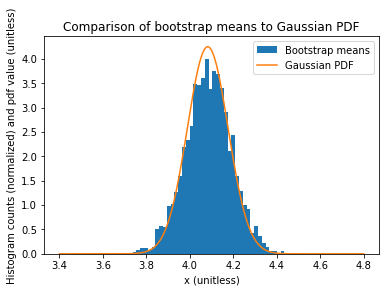

In [35]:
# MEK create a general x array to calculate a pdf for comparison
xgrid = np.linspace(3.4,4.8,1000)

# MEK plot pdf and bootstrap means in a histogram
plt.hist(means, bins=40, density=True, label="Bootstrap means")
plt.plot(xgrid, stats.norm.pdf(xgrid, loc=mu, scale=sigma), label="Gaussian PDF")
plt.title("Comparison of bootstrap means to Gaussian PDF")
plt.xlabel("x (unitless)")
plt.ylabel("Histogram counts (normalized) and pdf value (unitless)")
plt.legend()
plt.show()

SRT: Good!

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

In [36]:
# MEK leverage handy-dandy Laplace functions in scipy to take the ln(likelihood) for a Laplace distribution - make it negative because
# optimize.fmin minimizes functions
def lnL_laplace(x, mu, sigma):
    lnL = stats.laplace.logpdf(x, loc=mu, scale=sigma)
    lnL = -1*np.sum(lnL)
    return lnL

In [37]:
# MEK establish an initial guess, then optimize it
beta = (mu, sigma)
fit_laplace = lambda beta: lnL_laplace(data, beta[0], beta[1])
beta_fit_laplace, lnL_L_max, it_L, evals_L, warn_L = optimize.fmin(fit_laplace, beta,full_output=True)
print("Best fit mu and delta = ", beta_fit_laplace)

Optimization terminated successfully.
         Current function value: 161.631942
         Iterations: 60
         Function evaluations: 114
Best fit mu and delta =  [4.08779794 0.92604934]


SRT: Excellent

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?
$$ \mathrm{AIC}_M \equiv -2\ln[L^0(M)] + 2k + \frac{2k(k+1)}{N-k-1}, $$

In [38]:
# MEK calculate generic AIC values based on ln(likelihood), number of parameters (k) and number of samples (N)
def aic(lnL, k, N):
    aic = (-2*lnL)+(2*k)+(((2*k)*(k+1))/(N-k-1))
    return aic

In [39]:
# MEK calculate and return AIC values for the Gaussian and Laplace approaches
aic_G = aic(-lnL_G_max, 1, 2000)
aic_L = aic(-lnL_L_max, 2, 2000)

print("Gaussian:", "%.4f"%aic_G)
print("Laplace:", "%.4f"%aic_L)

Gaussian: 309.2391
Laplace: 327.2699


SRT: Nice

8) Using the $2000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

In [40]:
# MEK optimizing (simultaneously) a mu and delta value for all bootstrap samples
def laplace_mean(boots):
    means = []
    beta = beta_fit_laplace
    for sample in boots:
        data = sample[:,0]
        fit = lambda beta: lnL_laplace(data, beta[0], beta[1])
        beta_fit = optimize.fmin(fit, beta, disp=False)
        means.append(beta_fit)

    means = np.array(means)
    return means

In [41]:
# MEK time this
start = time.time()

# MEK calculate optimized values and finish timing
laplace_results = laplace_mean(boot)
end = time.time()

elapsed = end-start
print("Total run time =", "%.4f"%elapsed, "sec")

Total run time = 9.9802 sec


In [42]:
# MEK store best fit mu and delta values
laplace_mu = laplace_results[:,0]
laplace_delta = laplace_results[:,1]

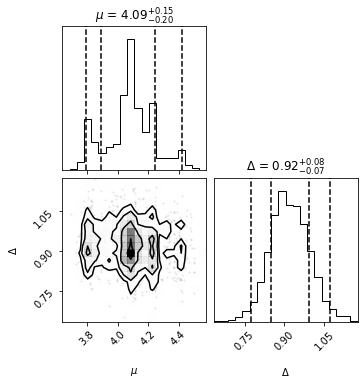

In [43]:
# MEK plot both distributions on a corner plot with dashed lines for 1sigma and 2sigma values
corner.corner(laplace_results, titles=[r"$\mu$",r"$\Delta$"], show_titles=True, labels=[r"$\mu$",r"$\Delta$"], \
              quantiles=[0.025, 0.16, 0.84, 0.975]);

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [44]:
# MEK borrow from SRT again for similar approach
H = nd.Hessian(fit_laplace)(beta_fit_laplace)
res = np.linalg.inv(H)**0.5

print("Fisher uncertainty estimate on mu =", "%.4f"%np.diag(res)[0])
print("Fisher uncertainty estimate on delta =", "%.4f"%np.diag(res)[1])

Fisher uncertainty estimate on mu = 0.1164
Fisher uncertainty estimate on delta = 0.0926


/tmp/ipykernel_122533/3174048791.py:3: RuntimeWarning: invalid value encountered in sqrt
  res = np.linalg.inv(H)**0.5


The widths look fairly similar to (8)! For $\mu$, the values are 0.15 above and 0.20 below, while the Fisher uncertainty is 0.12. For $\Delta$, the values are 0.07 in either direction, and the Fisher uncertainty is 0.09. Not too bad $\ddot\smile$

SRT: Well done!